In [1]:
import os

In [2]:
#!mkdir data
#!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
#!mkdir write

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc

In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.6.0 pandas==1.1.4 scikit-learn==0.24.0 statsmodels==0.12.1


In [5]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

In [6]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [8]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell


    finished (0:00:00)


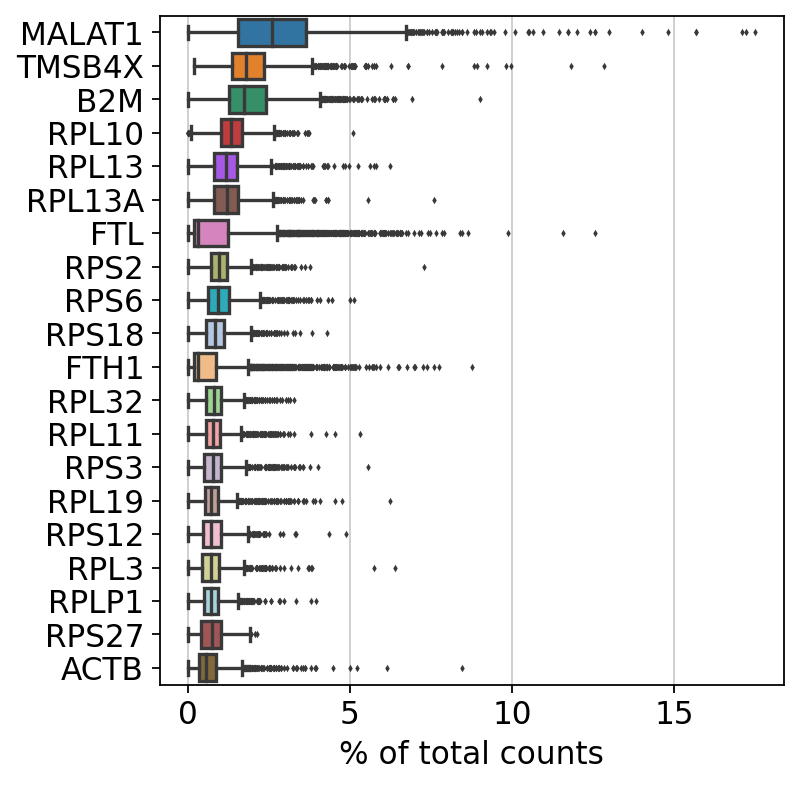

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [11]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/srv/conda/envs/notebook/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/srv/conda/envs/notebook/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/srv/conda/envs/notebook/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/srv/conda/envs/notebook/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/srv/conda/envs/notebook/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Ve

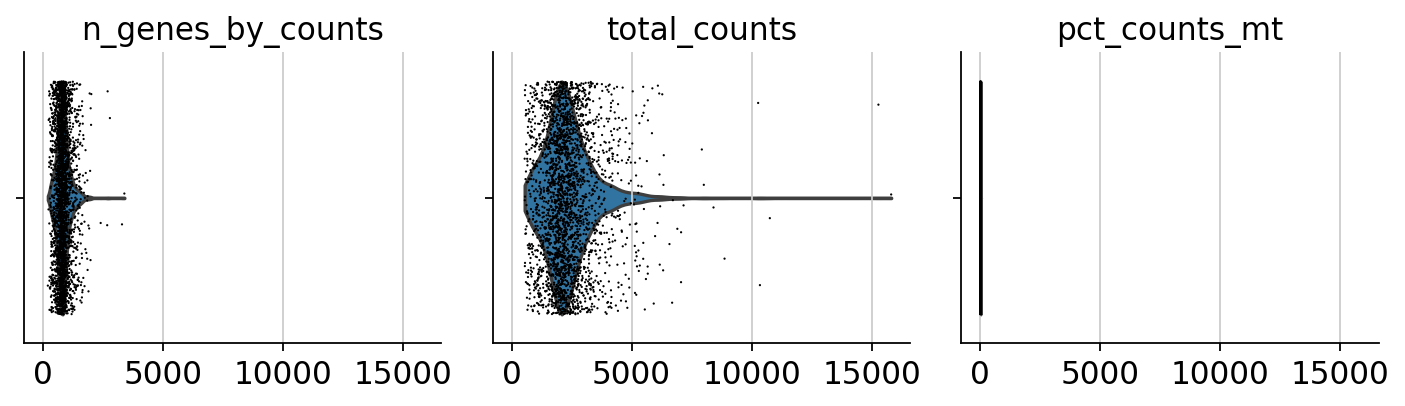

In [12]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

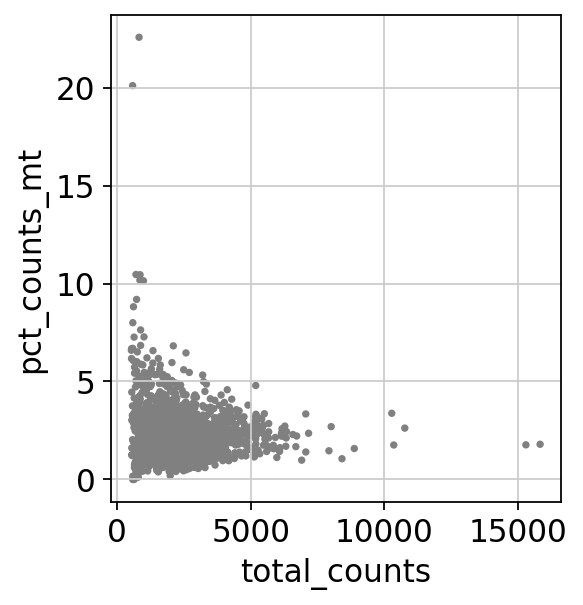

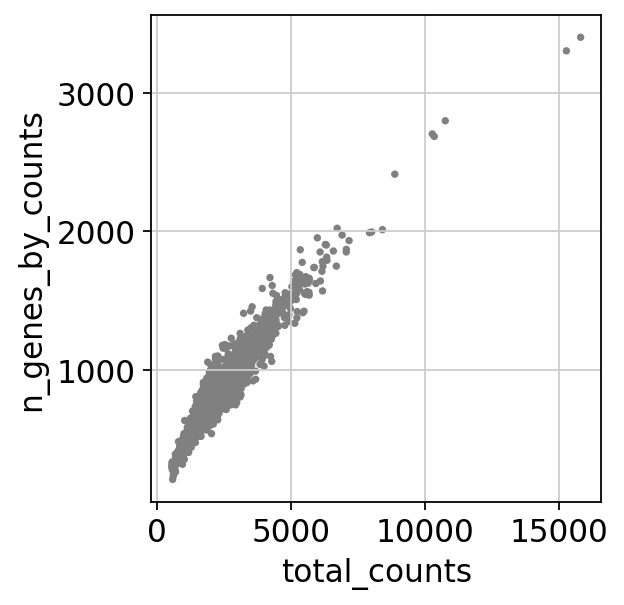

In [13]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [14]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell


    finished (0:00:00)


/srv/conda/envs/notebook/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [16]:
sc.pp.log1p(adata)

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes


    finished (0:00:00)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


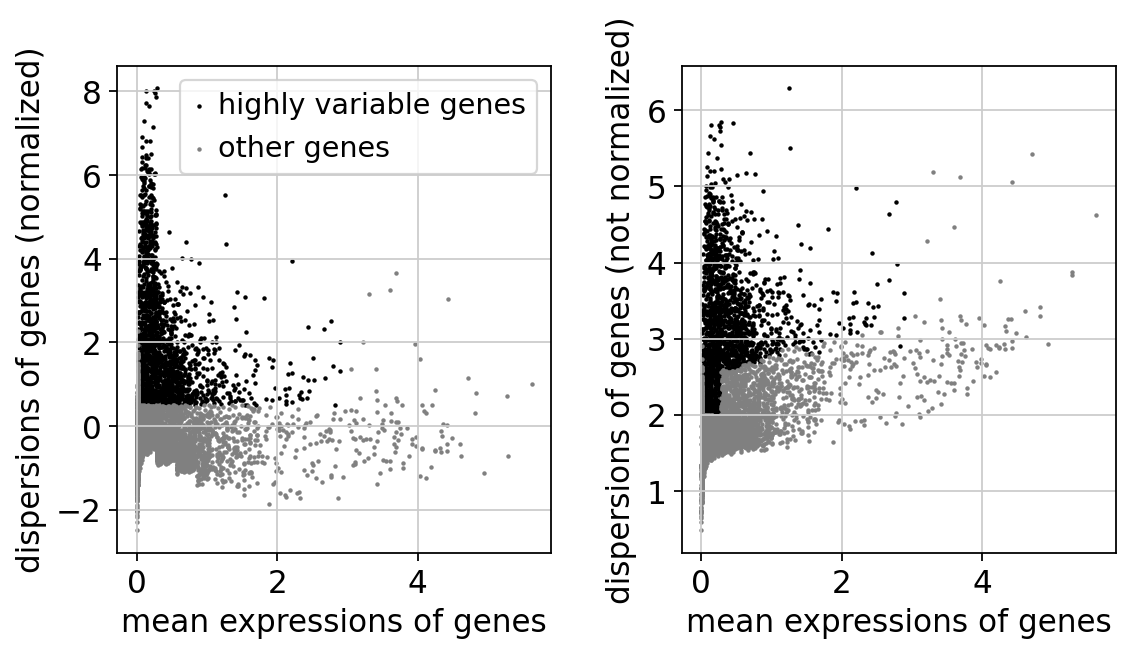

In [18]:
sc.pl.highly_variable_genes(adata)

In [19]:
adata.raw = adata

In [20]:
adata = adata[:, adata.var.highly_variable]

In [21]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']


    sparse input is densified and may lead to high memory use


    finished (0:00:09)


In [22]:
sc.pp.scale(adata, max_value=10)

In [23]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA


    on highly variable genes


    with n_comps=50


    finished (0:00:01)


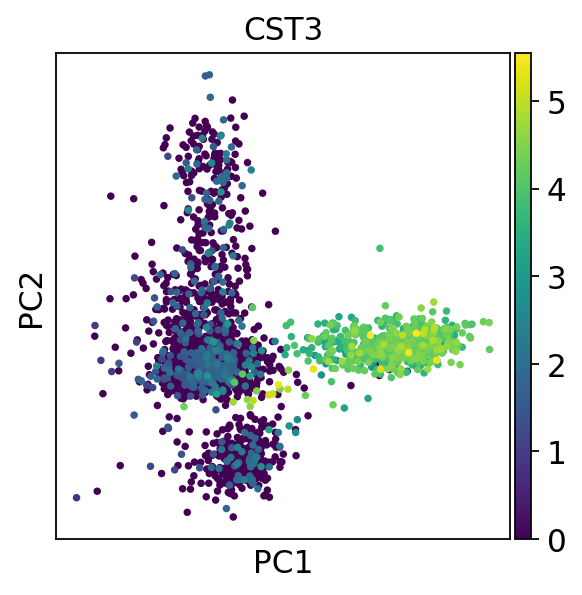

In [24]:
sc.pl.pca(adata, color='CST3')

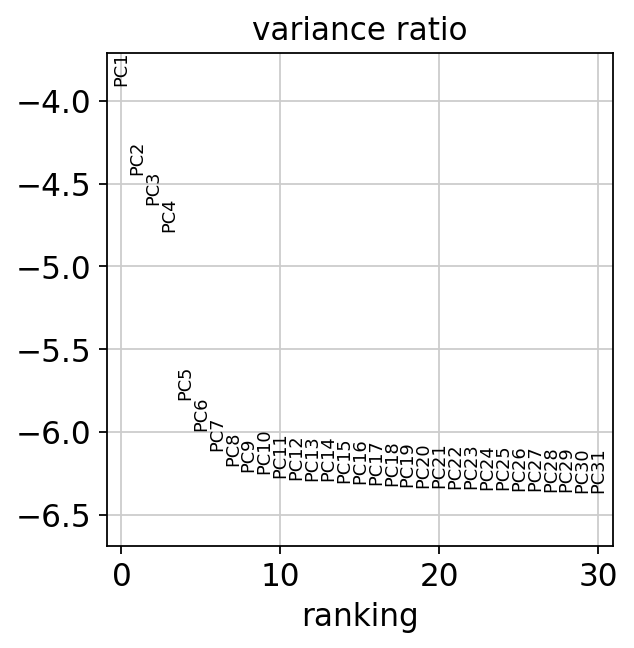

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

In [26]:
adata.write(results_file)

In [27]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors


    using 'X_pca' with n_pcs = 40


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [29]:
sc.tl.umap(adata)

computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


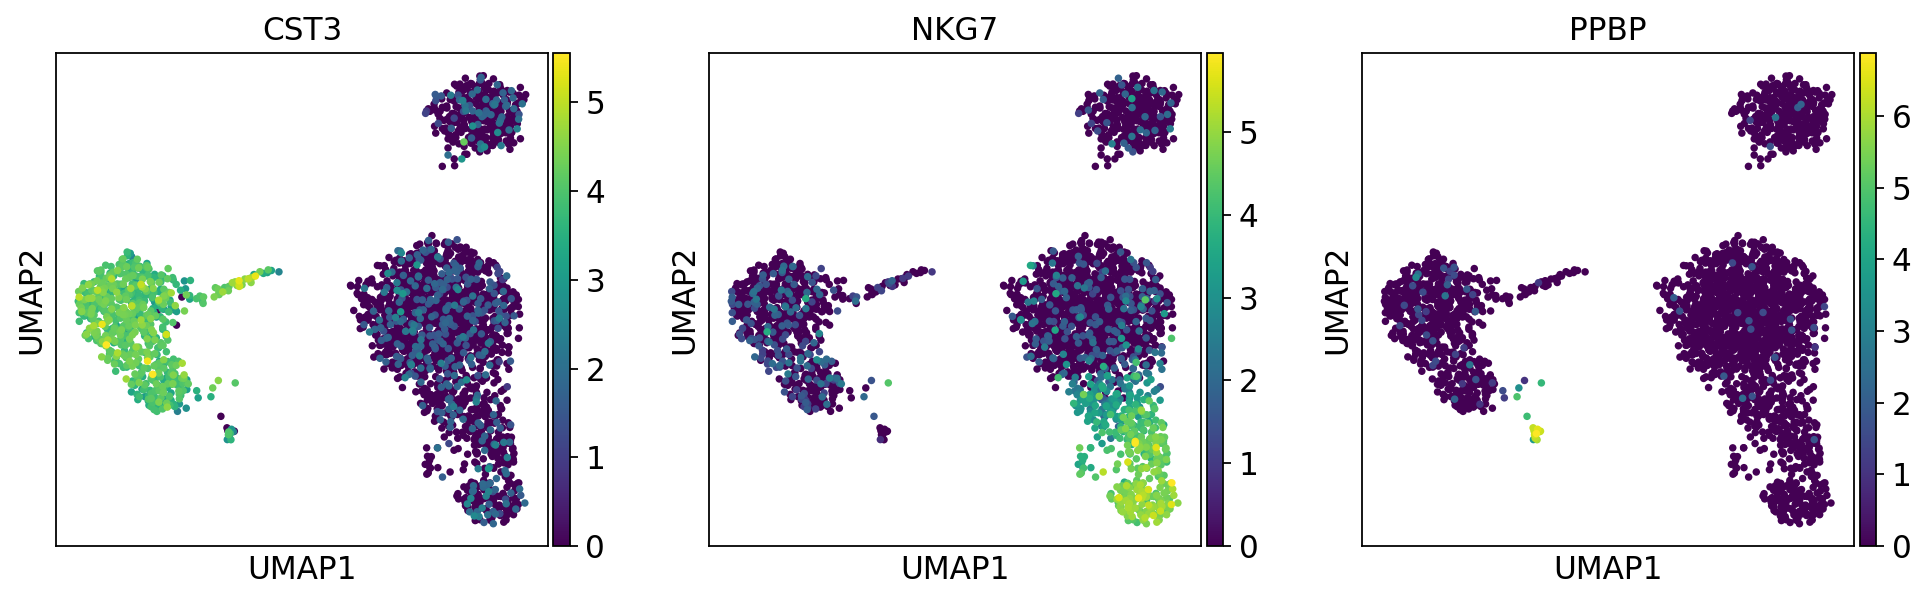

In [30]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

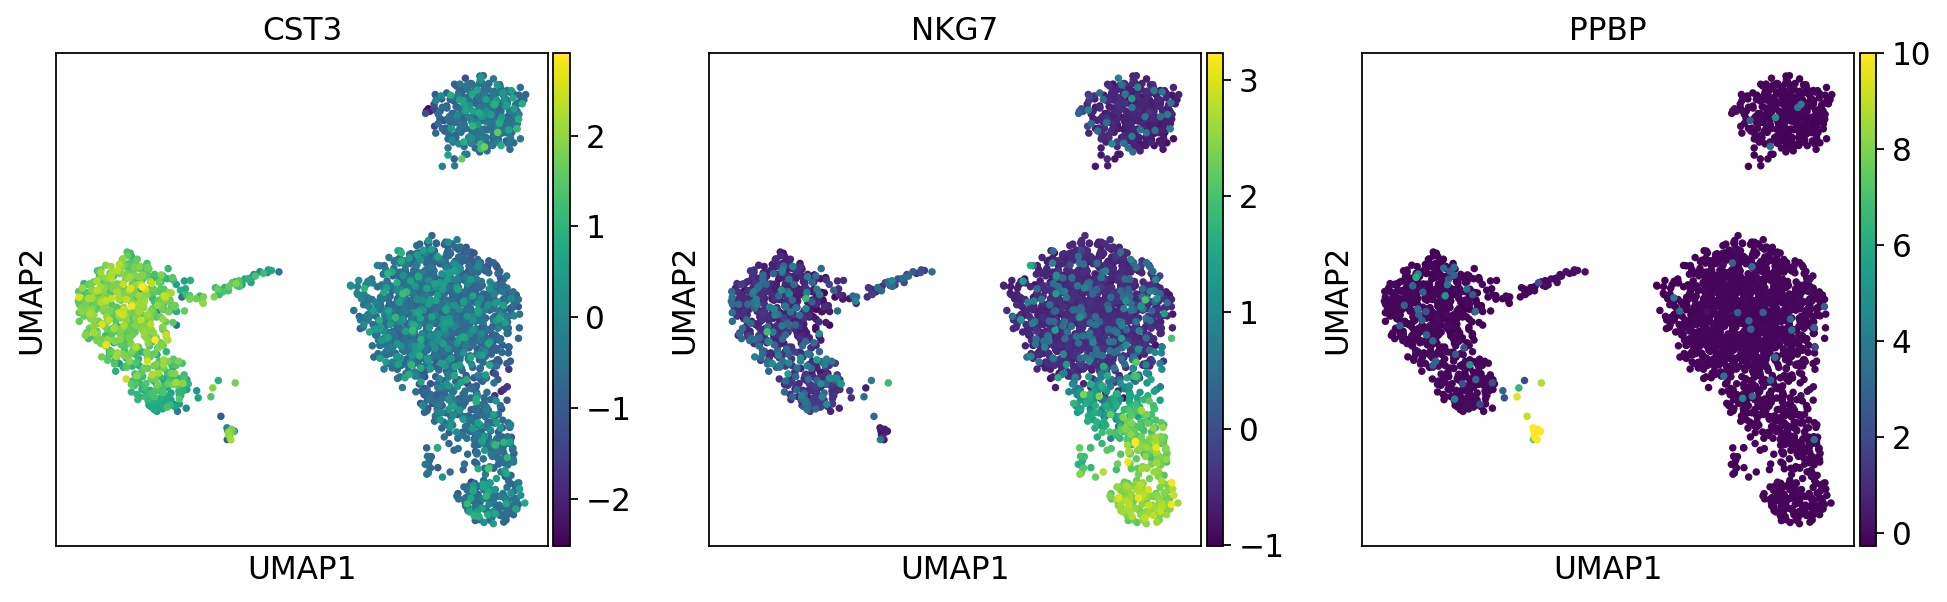

In [31]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [32]:
#! conda install -c conda-forge -y leidenalg pip

In [33]:
sc.tl.leiden(adata)

ImportError: Please install the leiden algorithm: `conda install -c conda-forge leidenalg` or `pip3 install leidenalg`.

In [34]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

KeyError: 'leiden'

<Figure size 1159.2x320 with 0 Axes>

In [35]:
adata.write(results_file)

In [36]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes


KeyError: 'leiden'

In [37]:
sc.settings.verbosity = 2  # reduce the verbosity

In [38]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes


KeyError: 'leiden'

In [39]:
adata.write(results_file)

In [40]:
#help(sc.tl.rank_genes_groups)

In [41]:
sc.tl.rank_genes_groups(adata,  'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes


KeyError: 'leiden'

In [42]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [43]:
adata = sc.read(results_file)

In [44]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

KeyError: 'names'

In [45]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

KeyError: 'names'

In [46]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

ranking genes


KeyError: 'leiden'

In [47]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

KeyError: 'names'

In [48]:
adata = sc.read(results_file)

In [49]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

KeyError: 'names'

In [50]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

KeyError: "Could not find keys '['leiden']' in columns of `adata.obs` or in `adata.raw.var_names`."

In [51]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

ValueError: leiden is neither in `.obs` nor in `.var`.

KeyError: 'leiden'

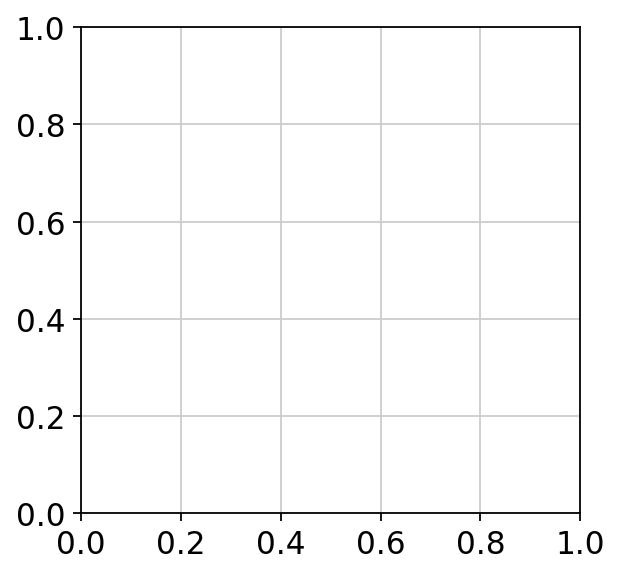

In [52]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

In [53]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

ValueError: groupby has to be a valid observation. Given leiden, is not in observations: ['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt']

In [54]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

ValueError: groupby has to be a valid observation. Given leiden, is not in observations: ['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt']

In [55]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [56]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

In [57]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

In [58]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )